# Continuous Wavelet Transform (CWT) on CWRU Bearing Data

**Datasets** : CWRU bearing vibration data (Normal_0 vs IR007_0)


## 1. Import libraries

In [3]:
import numpy as np
import scipy.io as sio
import pywt
import matplotlib.pyplot as plt

## 2. Load CWRU vibration signal

In [4]:
def load_cwru_signal(mat_path, signal_key, length=4096):
    mat = sio.loadmat(mat_path)
    signal = mat[signal_key].squeeze()
    signal = signal[:length]
    signal = (signal - np.mean(signal)) / np.std(signal)
    return signal

Now load both conditions:

In [5]:
normal_signal = load_cwru_signal(
    'datasets/cwru/Normal_0.mat',
    'X097_DE_time'                   # 'X097_DE_time', 'X097_FE_time', 'X097RPM'
)

ir007_signal = load_cwru_signal(
    'datasets/cwru/IR007_0.mat',
    'X105_DE_time'                  # 'X105_DE_time', 'X105_FE_time', 'X105_BA_time', 'X105RPM'
)

## 3. Sampling Information
**Why sampling information matters**
Vibration signals in the CWRU dataset are discrete-time signals obtained by sampling continuous mechanical vibrations at a fixed rate.

To correctly interpret:
- Time axis
- Frequency axis
- Wavelets scales

We must explicitly define the sampling frequency of the data

**Sampling frequency of CWRU data**
For the drive-end vibration signals used in this notebook:
- Sampling freqency (`fs`) : 12,000 Hz
- This means :
    - 12,000 samples are recorded every second
    - Each sample represents 1 / fs seconds

In [6]:
# Sampling frequency (Hz)
fs = 12000

## 4. Mother wavelet preparation
The mother wavelet must be selected because it determines how well the transform matches the signal characteristics, directly affecting time-frequency resolution and fault feature visibility.

> *Note: For rotating machinery vibration signals, the Morlet wavelet is commonly selected because its oscillatory shape closely matches mechanical vibration and provides clear fault-related patterns*

**Summary**
| Wavelet | Type | Oscillatory | Time Localization | Frequency Localization | Typical Use |
|-------|------|------------|-------------------|------------------------|------------|
| morl  | Real Morlet | Yes | High | High | Bearing & gear faults |
| cmor  | Complex Morlet | Yes | Medium | Very High | Frequency tracking |
| mexh  | Mexican Hat | No | Very High | Low | Impulse detection |
| gaus | Gaussian Derivative | No | Very High | Low | Shock / edge detection |
| paul | Paul | Yes | High | Medium | Envelope modulation |
| shan | Shannon | Yes | Low | Very High | Frequency separation |
| fbsp | B-spline | Yes | Medium | High | Research analysis |

In [7]:
wavelet = 'morl'    # Morlet wavelet

## 5. Scaling loop
The scaling loop in CWT analyzes the signal using multiple scaled versions of the mother wavelet.
For each scale, the wavelet is stretched or compressed to capture signal features at different frequency resolutions.

Although the scaling loop is not explicitly implemented, the `pywt.cwt()` function internally iterates over all specified scales and applies the wavelet transform independently at each scale.

In [8]:
scales = np.arange(1, 129)

## 6. CWT Computation (Convolution Process)

The Continuous Wavelet Transform (CWT) computes a time–scale representation
by correlating the signal with scaled versions of a mother wavelet.

For each scale:
1. The wavelet is stretched or compressed (scaling)
2. The scaled wavelet is slid across the signal
3. A similarity coefficient is computed at every time point

For efficiency, FFT-based convolution is used internally.

In [9]:
coeffs_N, freqs_N = pywt.cwt(
    normal_signal,
    scales,
    wavelet,
    sampling_period=1/fs
)

coeffs_I, freqs_I = pywt.cwt(
    ir007_signal,
    scales,
    wavelet,
    sampling_period=1/fs
)

## 7. Structure of CWT Output

The CWT returns a 2D coefficient matrix for each signal.

The shape of the output reveals how the transform is organized.

### Interpretation of the Shape

(coefficients shape) = (number of scales, number of time samples)

- Rows → scales (≈ frequency bands)
- Columns → time samples
- Each value → similarity between the signal and the scaled wavelet

Example: 
(128, 4096)
- 128 frequency-like bands
- 4096 time locations

In [12]:
print("Normal signal CWT shape:", coeffs_N.shape)
print("Fault signal CWT shape:", coeffs_I.shape)

Normal signal CWT shape: (128, 4096)
Fault signal CWT shape: (128, 4096)


## 8. CWT Coefficient Interpretation

Each CWT coefficient measures how strongly a specific frequency pattern
appears at a specific time.

In practice, we analyze the **magnitude** of the coefficients.

### Interpretation Guidelines

| Observation | Interpretation |
|------------|----------------|
| Large magnitude | Strong presence of that frequency |
| Small magnitude | Weak or no presence |
| Vertical energy streaks | Impulsive faults |
| Horizontal ridges | Persistent harmonic components |

In [ ]:
cwt_mag_N = np.abs(coeffs_N)
cwt_mag_I = np.abs(coeffs_I)

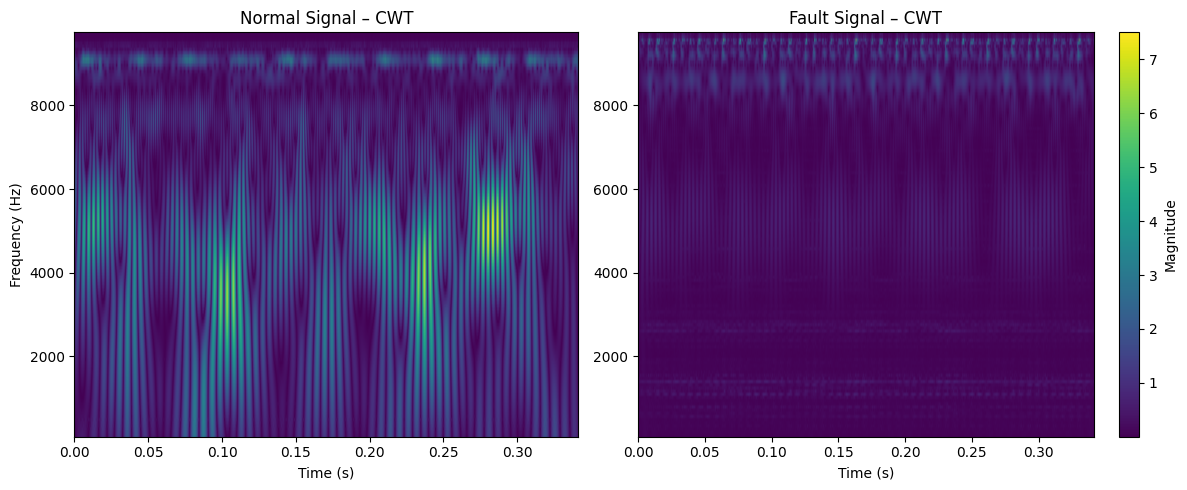

In [15]:
plt.figure(figsize=(12, 5))

# Normal
plt.subplot(1, 2, 1)
plt.imshow(
    np.abs(coeffs_N),
    extent=[0, len(normal_signal)/fs, freqs_N[-1], freqs_N[0]],
    aspect='auto'
)
plt.title('Normal Signal – CWT')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# Fault
plt.subplot(1, 2, 2)
plt.imshow(
    np.abs(coeffs_I),
    extent=[0, len(ir007_signal)/fs, freqs_I[-1], freqs_I[0]],
    aspect='auto'
)
plt.title('Fault Signal – CWT')
plt.xlabel('Time (s)')

plt.colorbar(label='Magnitude', fraction=0.046)
plt.tight_layout()
plt.show()

## 8. Scalogram construct (Time-scale energy map)

**What you should observe**
- Normal
    - Smooth energy distribution
    - Dominant low-frequency components
- IR007 Fault
    - Hight-energy bursts
    - Strong high-frequency components (impulses)
    - Clear non-stationary behavior

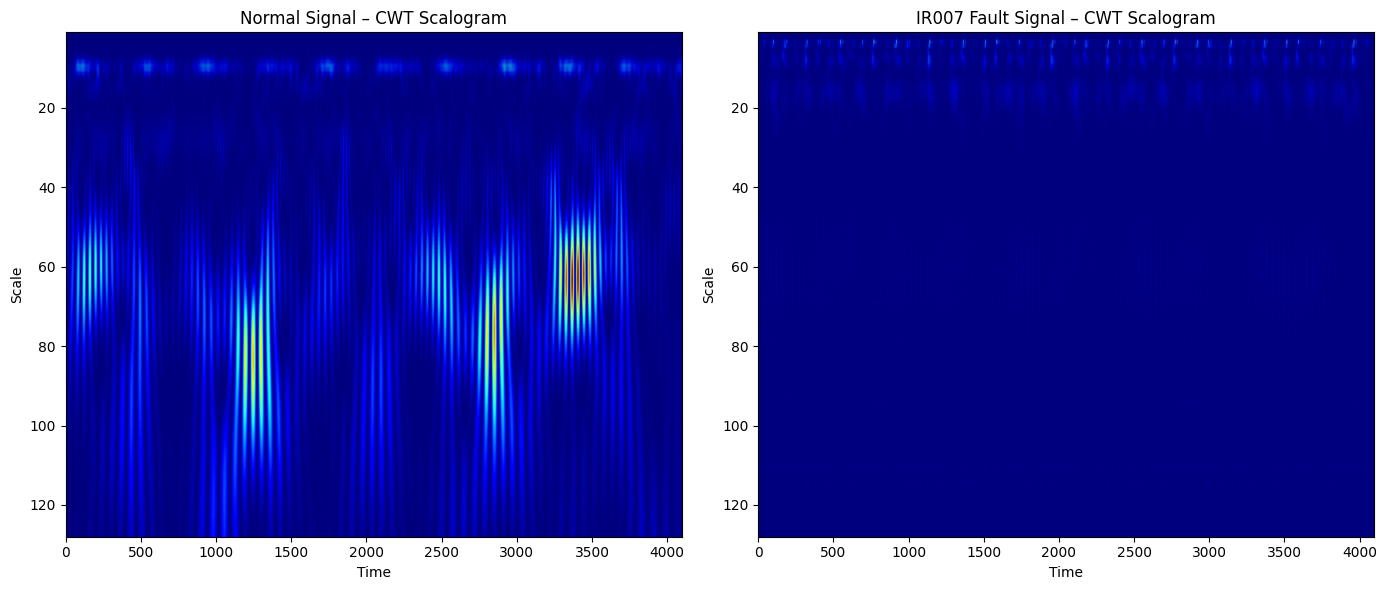

In [11]:
energy_N = np.abs(coeffs_N) ** 2
energy_I = np.abs(coeffs_I) ** 2

# Visualization: Normal vs Fault
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(
    energy_N,
    extent=[0, len(normal_signal), scales[-1], scales[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('Normal Signal – CWT Scalogram')
plt.xlabel('Time')
plt.ylabel('Scale')

plt.subplot(1, 2, 2)
plt.imshow(
    energy_I,
    extent=[0, len(ir007_signal), scales[-1], scales[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('IR007 Fault Signal – CWT Scalogram')
plt.xlabel('Time')
plt.ylabel('Scale')

plt.tight_layout()
plt.show()

## 8. Frequency Mapping

- Converts abstract scale values to physical frequency (Hz)
- Enables fault frequency interpretation (BPFO, BPFI, etc.)

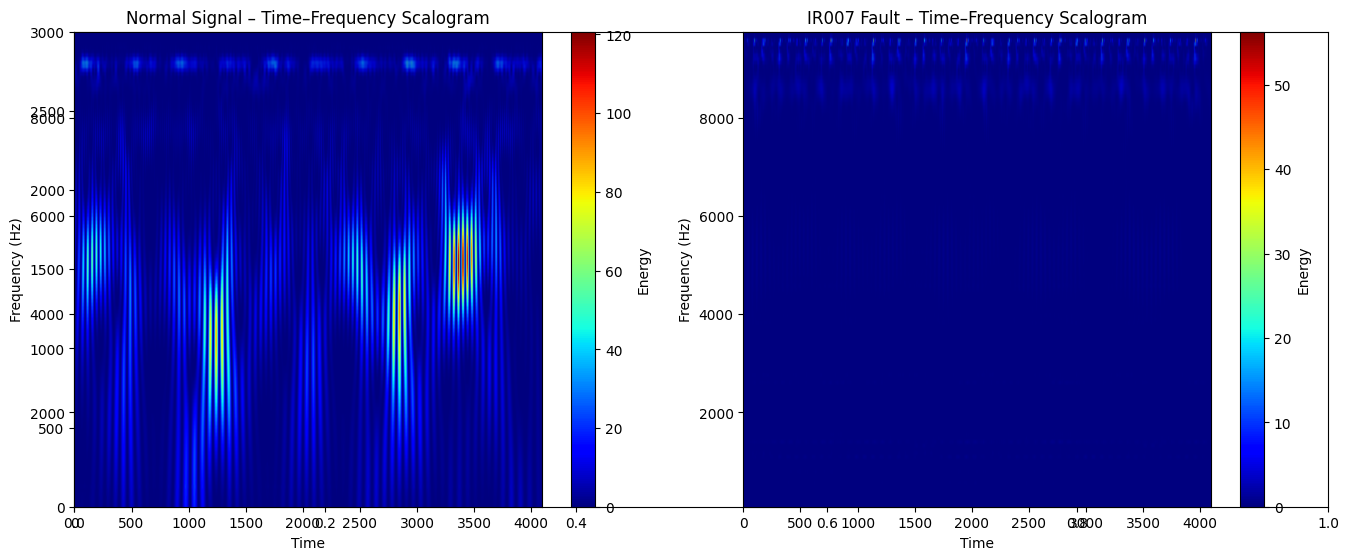

In [ ]:
sampling_frequency = 12000  # Hz (CWRU DE signal)

frequencies = pywt.scale2frequency(wavelet, scales) * sampling_frequency

# Visualize: Normal vs IR007
plt.figure(figsize=(14, 6))

# Normal signal
plt.subplot(1, 2, 1)
plt.imshow(
    energy_N,
    extent=[0, len(normal_signal), frequencies[-1], frequencies[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('Normal Signal – Time–Frequency Scalogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Energy')

# IR007 fault signal
plt.subplot(1, 2, 2)
plt.imshow(
    energy_I,
    extent=[0, len(ir007_signal), frequencies[-1], frequencies[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('IR007 Fault – Time–Frequency Scalogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Energy')

plt.tight_layout()
plt.show()

## Flow Chart

In [16]:
from mermaid import Mermaid

Mermaid("""
graph TD
    %% Define Nodes
    A([Start: Input Signal]) --> B[<b>1. Mother Wavelet Prep</b><br/>Define base wavelet function]
    B --> C[<b>2. Scaling Loop</b><br/>Iterate through scales a=1, 2, 3...]
    
    subgraph Processing [Core Computation]
        C --> D[<b>3. Resampling</b><br/>Stretch/Compress wavelet to scale 'a']
        D --> E{<b>4. Convolution</b><br/>Select Method}
        E -->|Short Data| F[Direct Time-Domain]
        E -->|Long Data| G[FFT Multiplication]
        F --> H[<b>5. Coefficient Extraction</b>]
        G --> H
    end

    H --> I{All scales<br/>complete?}
    I -- No --> C
    I -- Yes --> J[<b>6. Frequency Mapping</b><br/>Convert scale units to Hz]
    
    J --> K[/<b>Output: Scalogram</b><br/>2D Time-Frequency Map/]
    K --> L([End])

    %% Styling
    style Processing fill:#fdfdfd,stroke:#333,stroke-width:2px
    style E fill:#e1f5fe,stroke:#01579b
""")

## Visualization

GIF 저장 완료


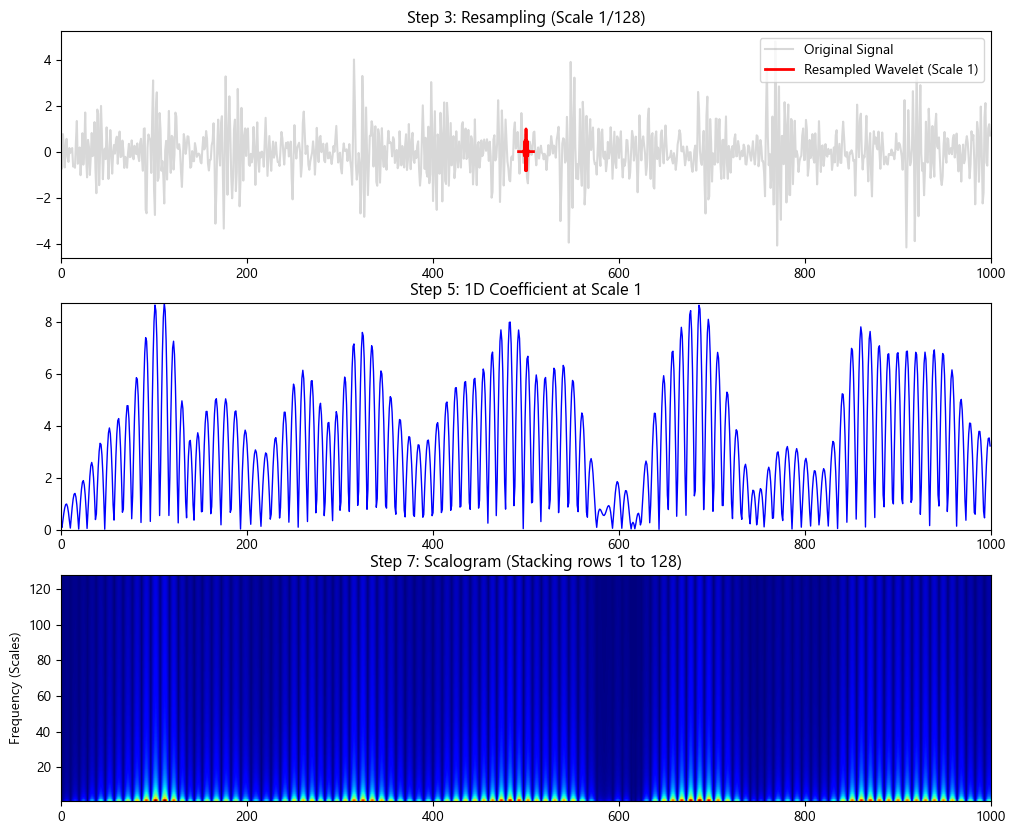

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# -----------------------------
# 1. Parameters & Data (사용자 원본 설정 적용)
# -----------------------------
# signal = normal_signal[:1000] # 분석 구간 설정
signal = ir007_signal[:1000] # 분석 구간 설정
fs = 12000
dt = 1/fs
scales = np.arange(1, 129)   # 사용자 지정 원본 스케일 (1~128)
wavelet_name = 'morl'

# 2D 계수 행렬 미리 준비 (Step 7: Scalogram Stacking용)
manual_coeffs = np.zeros((len(scales), len(signal)))

# 시각화 레이아웃
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(3, 1, 1) # Step 3 & 4: Resampling & Translation
ax2 = plt.subplot(3, 1, 2) # Step 5: 1D Coefficient 추출
ax3 = plt.subplot(3, 1, 3) # Step 7: Scalogram 이미지 누적

# -----------------------------
# 2. Animation Update Function
# -----------------------------
def update(frame_scale):
    # frame_scale은 0부터 127까지 증가 (Scaling Loop의 반복)
    a = scales[frame_scale]
    
    # --- Step 3: Resampling (스케일링 루프 내 핵심 동작) ---
    wavelet = pywt.ContinuousWavelet(wavelet_name)
    psi, x = wavelet.wavefun(level=8)
    
    # --- Step 4 & 5: 전체 구간에 대해 Convolution 및 계수 추출 ---
    # 애니메이션 속도를 위해 각 스케일의 전체 계수를 한 번에 계산
    # (실제 내부 동작인 '슬라이딩' 결과물을 한 줄로 요약)
    current_row = np.abs(np.convolve(signal, psi, mode='same')) / np.sqrt(a)
    manual_coeffs[frame_scale, :] = current_row
    
    # --- 그래프 업데이트 ---
    
    # Ax1: 현재 스케일(a)에서 리샘플링된 웨이블릿의 크기 시각화
    ax1.cla()
    ax1.plot(signal, color='gray', alpha=0.3, label='Original Signal')
    # 중앙 부근에 웨이블릿 하나를 표시하여 '크기(Resampling)' 변화를 보여줌
    ax1.plot(x * a + 500, psi, 'r', lw=2, label=f'Resampled Wavelet (Scale {a})')
    ax1.set_title(f"Step 3: Resampling (Scale {a}/128)")
    ax1.set_xlim(0, len(signal))
    ax1.legend(loc='upper right')

    # Ax2: 현재 스케일에서 추출된 1D 계수 (Scalogram의 한 줄)
    ax2.cla()
    ax2.plot(current_row, color='blue', lw=1)
    ax2.set_title(f"Step 5: 1D Coefficient at Scale {a}")
    ax2.set_xlim(0, len(signal))
    ax2.set_ylim(0, np.max(manual_coeffs) if np.max(manual_coeffs) > 0 else 1)

    # Ax3: 스칼로그램 스태킹 (아래에서 위로 쌓임)
    # 한 줄씩 에너지가 채워지는 모습 시각화
    ax3.cla()
    ax3.imshow(manual_coeffs, aspect='auto', cmap='jet', origin='lower',
               extent=[0, len(signal), scales[0], scales[-1]])
    ax3.set_title("Step 7: Scalogram (Stacking rows 1 to 128)")
    ax3.set_ylabel("Frequency (Scales)")

    return []

# 애니메이션 생성 (모든 128개 스케일에 대해 반복)
ani = FuncAnimation(fig, update, frames=len(scales), interval=50, blit=False)
ani.save('CWT_Analysis.gif', writer='pillow', fps=20)
print("GIF 저장 완료")
# plt.tight_layout()
# HTML(ani.to_jshtml())